# Kernel Search

## Setup

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import gpflow
from gpflow.utilities import print_summary, set_trainable
# import helper_functions as hf
# from helper_functions import (
#     Categorical, kernel_test, 
#     kernel_search, gp_predict_fun
# )

In [9]:
# Libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import gpflow
from gpflow.utilities import set_trainable
import re

# Classes
class Categorical(gpflow.kernels.Kernel):
    def __init__(self, active_dims):
        super().__init__(active_dims=active_dims)
        self.variance = gpflow.Parameter(
            1.0, 
            transform=gpflow.utilities.positive()
        )
        
    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        return (self.variance * 
                tf.cast(tf.equal(X, tf.reshape(X2,[1,-1])),
                        tf.float64))
    
    def K_diag(self, X):
        return self.variance * tf.reshape(X, (-1,))

# Helper functions
def gp_predict_fun(gp, X, Y, x_min, x_max, x_idx, unit_idx, unit_label, num_funs=10):  
    """
    Plot marginal closed-form posterior distribution.
    """
    
    # Create test points
    x_new = np.zeros_like(X)
    x_new[:,x_idx] = np.linspace(x_min, x_max, X.shape[0])
    x_new[:, unit_idx] = unit_label

    # Predict mean and variance on new data
    mean, var = gp.predict_f(x_new)

    # Pull some posterior functions
    tf.random.set_seed(1) 
    samples = gp.predict_f_samples(x_new, num_funs) 

    # Generate plot
#     p = plt.figure(figsize=(10, 5))
    fig, ax = plt.subplots(figsize=(10,5))
#     p = sns.scatterplot(x=X[:,x_idx],
#                     y=Y.flatten(),
#                     hue=X[:,unit_idx].astype(int).astype(str),
#                         legend=False)
    person_rows = X[:,unit_idx] == unit_label
    p = sns.scatterplot(x=X[person_rows,x_idx],
                    y=Y.flatten()[person_rows],
#                     hue=X[:,unit_idx].astype(int).astype(str),
#                         legend=False
                       s=100,
                       color='black')
    p = sns.scatterplot(x=X[~np.array(person_rows),x_idx],
                    y=Y.flatten()[~np.array(person_rows)],
#                     hue=X[:,unit_idx].astype(int).astype(str),
#                         legend=False
                       s=10,
                       color='grey')
    p = sns.lineplot(x=x_new[:,x_idx],
                 y=mean.numpy().flatten(),
                 linewidth=2,
                    color='darkgreen')
    p.fill_between(
        x_new[:, x_idx],
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        color='lightgreen',
        alpha=0.5,
    )
    p.plot(x_new[:,x_idx], 
           samples[:, :, 0].numpy().T,# "C0", 
           color='dimgray',
           linewidth=0.5)
#     plt.close()
    return(p)

def calc_bic(loglik, n, k):
    return k*np.log(n)-2*loglik

# Kernel search helper functions
def coregion_freeze(k):
    """ Freeze parameters associated with coregion kernel, for individual level effets. """
    
    if k.name == 'coregion':
        #print('Found coregion kernel, freezing parameters.')
        k.W.assign(np.zeros_like(k.W))
        k.kappa.assign(np.ones_like(k.kappa))
        set_trainable(k.W, False)
        set_trainable(k.kappa, False)
#         set_trainable(k, False)

def coregion_search(kern_list):
    """ Search through GP kernel list to find coregion kernels. """
    
    for k in kern_list:
        if hasattr(k, 'kernels'):
            coregion_search(k.kernels)
        else:
            coregion_freeze(k)

def print_kernel_names(kernel):
    names = []
    if hasattr(kernel,'kernels')==False:
        return kernel.name
    for i in kernel.kernels:
        if i.name == 'sum':
            sub_names = print_kernel_names(i)
#             names.append('+'.join([x.name for x in i.kernels]))
            names.append('+'.join(sub_names))

        elif i.name == 'product':
            sub_names = print_kernel_names(i)
#             names.append('*'.join([x.name for x in i.kernels]))
            names.append('*'.join(sub_names))

        else:
            names.append(i.name)

    return(names)

def kernel_test(X, Y, k, num_restarts=5, verbose=False):
    """
    This function evaluates a particular kernel selection on a set of data. 
    
    Inputs:
        X (array): design matrix
        Y (array): output matrix
        k (gpflow kernel): specified kernel
        
    Outputs:
        m (gpflow model): fitted GPflow model
    
    """
            
    # Randomize initial values for a number of restarts
    np.random.seed(9012)
    best_loglik = -np.Inf
    best_model = None
        
    for i in range(num_restarts):
        
        # Specify model
        m = gpflow.models.GPR(data=(X, Y),
                              kernel=k,
                              mean_function=None)
        
        # Randomize initial values if not trained already
        for p in m.trainable_parameters:
            if p.numpy() == 1:
                p.assign(
                    np.random.uniform(
                        size=p.numpy().size
                    ).reshape(p.numpy().shape)
                )
        
        # Optimization step for hyperparameters
        opt_results = gpflow.optimizers.Scipy().minimize(
            m.training_loss,
            m.trainable_variables)
        
#         print(opt_results)
        
        # Check if better values found and save if so
        if m.log_marginal_likelihood() > best_loglik:
            best_loglik = m.log_marginal_likelihood()
            best_model = m
            if verbose:
                print(f'New best log likelihood: {best_loglik.numpy()}')
            
#     # Set hyperparameters to best found values
#     for l in range(len(m.trainable_parameters)):
#         print(best_params[l])
#         m.trainable_parameters[l].assign(best_params[l])    

    # Calculate information criteria
    bic = round(calc_bic(loglik=best_model.log_marginal_likelihood().numpy(),
                   n=X.shape[0],
                   k=len(m.trainable_parameters)),
               2)
    
    # Print out info if requested
    if verbose:
        print(f'Model: {print_kernel_names(k)}, BIC: {bic}')
    
    # Return fitted GP model and bic
    # Predictions
#     print(best_model.predict_f(X))
    return best_model, bic

In [3]:
# Read data in
# Full data
df = pd.read_csv('simulated_data.csv')

# Break out features
X = (df[['unit', 'treatment', 'time']]
         .to_numpy()
         .reshape(-1,3))

# And outputs
Y = (df[['k1_obs', 'k2_obs', 'k3_obs', 'k4_obs']]
         .to_numpy()
         .reshape(-1,4))

# Show a few rows
df.head()

,unit,treatment,time,k1_obs,k2_obs,k3_obs,k4_obs
0,0.0,0.0,2.5,2.03,-2.34,1.15,-0.66
1,0.0,0.0,5.1,0.66,-2.35,1.97,-0.30
2,0.0,0.0,5.5,1.08,-1.57,1.94,-0.57
3,0.0,0.0,6.1,0.88,-1.25,2.09,-0.19
4,0.0,0.0,6.8,0.61,-0.11,2.20,-0.25


## Kernel Search

Selecting list of kernels to search over for continuous features as a small number with very different behaviors. This is subject to change and allow for individual inputs.

In [4]:
# Specify kernel list to search over
kernel_list = [gpflow.kernels.White(),
               gpflow.kernels.Linear(),
               gpflow.kernels.SquaredExponential()]

### Kernel 1
Start by searching over the feature space for the first kernel only. Looking to recover the individual offset + matern32 over time.

In [5]:
# Libraries
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from gpflow.ci_utils import ci_niter
f64 = gpflow.utilities.to_default_float

@tf.function
def run_chain_fn(num_samples, num_burnin_steps, hmc_helper, adaptive_hmc):
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
    )

def hmc_sampling(model, burn_in=500, samples=500):

    # Set priors
    for p in model.parameters:
        p.prior = tfd.Gamma(f64(1), f64(1))
    
    # Set helper
    hmc_helper = gpflow.optimizers.SamplingHelper(
        model.log_posterior_density,
        model.trainable_parameters
    )
    
    # Set HMC options
    hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=hmc_helper.target_log_prob_fn,
        num_leapfrog_steps=10,
        step_size=0.01
    )
    adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
        hmc,
        num_adaptation_steps=10,
        target_accept_prob=f64(0.80),
        adaptation_rate=0.1
    )
    
    # Run sampler
    samples, traces = run_chain_fn(
        num_samples=ci_niter(samples),
        num_burnin_steps=ci_niter(burn_in),
        hmc_helper=hmc_helper,
        adaptive_hmc=adaptive_hmc
    )
    
    # Get constrained values
    strain_samples = hmc_helper.convert_to_constrained_values(samples)
    
    return strain_samples, samples, traces

m = gpflow.models.GPR(data=(X, Y[:, 0].reshape(-1, 1)),
                      kernel=gpflow.kernels.SquaredExponential(active_dims=[2]),
                      mean_function=None)

for p in m.trainable_parameters:
    p.assign(
        np.random.uniform(
            size=p.numpy().size
        ).reshape(p.numpy().shape)
    )

gpflow.optimizers.Scipy().minimize(
    m.training_loss,
    m.trainable_variables)

p = gp_predict_fun(gp=m, X=X, Y=Y[:, 0].reshape(-1, 1), 
                   x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=0)

# HMC test
c_samples, samples, trace = hmc_sampling(model=m)

def plot_samples(samples, parameters, y_axis_label):
    plt.figure(figsize=(8, 4))
    for val, param in zip(samples, parameters):
        plt.plot(tf.squeeze(val), label=param_to_name[param])
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.xlabel("HMC iteration")
    plt.ylabel(y_axis_label)

param_to_name = {param: name for name, param in 
                 gpflow.utilities.parameter_dict(m).items()}
plot_samples(c_samples, m.trainable_parameters, 
             "constrained parameter values")

# from helper_functions import kernel_test
m, bic = kernel_test(X=X,
            Y=Y[:,0].reshape(-1, 1),
            k=gpflow.kernels.SquaredExponential(active_dims=[2]))
m
p = gp_predict_fun(gp=m, X=X, Y=Y[:, 0].reshape(-1, 1), 
                   x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=0)

In [56]:
def set_feature_kernels(f, kern_list, cat_vars):
    if f in cat_vars:
        k_list = [Categorical(active_dims=[f])]
    else:
        k_list = kern_list.copy()
        for k_ in k_list:
            k_.active_dims = np.array([f])
    return k_list

def loc_kernel_search(X, Y, kern_list, 
                      base_kern=None, base_name=None, 
                      cat_vars=[],
                      depth=0,
                      operation='sum',
                      prod_index=None):
    """
    This function does blah, blah, blah.
    """
    
    bic_dict = {} 
    
    # Search over features in X
    for f in np.arange(X.shape[1]):
#         print(f'Working on feature {f} now')
        temp_kern_list = [gpflow.utilities.deepcopy(x) for x in kern_list]
        # Set kernel list based on feature currently searching
        k_list = set_feature_kernels(f=f,
                                     kern_list=temp_kern_list,
                                     cat_vars=cat_vars)
            
        # Search over kernels
        for k in k_list:
            
            # Get kernel name and dimension
            k_info = k.name + str(k.active_dims)
            
            # Update kernel information with base if possible
            if base_kern != None:
#                 # Check if the new kernel is a copy of the previous categorical kernel
#                 # this would be redundant
#                 if k.name == 'categorical' and k_info in base_name:
#                     continue
                if operation == 'sum':
                    # Skip operation if categorical kernel exists
                    if 'categorical' in k_info and k_info in base_name:
                        continue

                    k = gpflow.kernels.Sum(kernels = [base_kern, k])
                    k_info = base_name + '+' + k_info
                    m, bic = kernel_test(X, Y, k)
                    bic_dict[k_info] = [k, m, bic, depth]
                    
                elif operation == 'product':       
                    # Skip operation if categorical kernel exists
                    if 'categorical' in k_info and k_info in base_name:
                        continue
                        
                    # Set new variance to 1, don't train
                    set_trainable(k.variance, False)
                    k = gpflow.kernels.Product(kernels = [base_kern, k])
                    k_info = base_name + '*' + k_info
                    m, bic = kernel_test(X, Y, k)
                    bic_dict[k_info] = [k, m, bic, depth]
                    
                elif operation == 'split_product':
                    # Set new variance to 1, don't train
                    set_trainable(k.variance, False)
                    new_dict = prod_kernel_creation(X=X,
                                                    Y=Y,
                                                    base_kernel=base_kern,
                                                    base_name=base_name,
                                                    new_kernel=k,
                                                    depth=depth)
                    bic_dict.update(new_dict)
            else:
                m, bic = kernel_test(X, Y, k)
                bic_dict[k_info] = [k, m, bic, depth]
                    
            # Set kernel based on feature
#             try:
#             m, bic = kernel_test(X, Y, k)
#             except:
#                 print('Kernel test failed!')
#                 continue
            
            
            # Save BIC results
#             bic_dict[k_info] = [k, m, bic, depth]
            
            
    return bic_dict

def prod_kernel_creation(X, Y, base_kernel, base_name, new_kernel, depth):
    """
    Produce kernel for product operation
    """
    
    bic_dict = {}
    
    for feat in range(len(base_kernel.kernels)):
        temp_kernel = gpflow.utilities.deepcopy(base_kernel)
        temp_kernel.kernels[feat] = temp_kernel.kernels[feat] * new_kernel
        temp_name = base_name.split('+')
        k_info = new_kernel.name + str(new_kernel.active_dims)
        # Skip operation if categorical kernel exists
        if 'categorical' in k_info and k_info in temp_name[feat]:
            continue
        
        temp_name[feat] = temp_name[feat] + '*' + k_info
        k_info = '+'.join(temp_name)
        
        m, bic = kernel_test(X, Y, temp_kernel)
        bic_dict[k_info] = [temp_kernel, m, bic, depth]
        
    return bic_dict

def check_if_better_metric(previous_dict, current_dict):
    """
    Check to see if a better metric was found in current layer, otherwise end search.
    """
    
    best_prev = min(x[2] for x in previous_dict.values())
    best_new = min(x[2] for x in current_dict.values())
    
    return True if best_new < best_prev else False

def keep_top_k(res_dict, depth, metric_diff = 6):
    
    best_bic = np.Inf
    out_dict = res_dict.copy()
    
    # Find results from the current depth
    best_bic = min([v[2] for k,v in res_dict.items() if v[3] == depth])
#     for k,v in res_dict.items():
#         if v[3] == depth and v[2] < best_bic:
    
    # Only keep results in diff window
    for k,v in res_dict.items():
        if v[3] == depth and (v[2]-best_bic) > metric_diff:
            out_dict.pop(k)
        
    return out_dict

def full_kernel_search(X, Y, kern_list, cat_vars=[], max_depth=5, keep_all=False):
    """ 
    This function runs the entire kernel search, calling helpers along the way.
    """
    
    # Create initial dictionaries to insert
    search_dict = {}
    edge_list = []
    
    # Go through each level of depth allowed
    for d in range(1, max_depth+1):
        print(f'Working on depth {d} now')
        # If first level then there is no current dictionary to update
        if d == 1:
            search_dict = loc_kernel_search(
                X=X, 
                Y=Y, 
                kern_list=kern_list, 
                cat_vars=cat_vars,
                depth=d
            )
        else:
            # Create temporary dictionary to hold new results
            temp_dict = search_dict.copy()
            for k in search_dict.keys():
                cur_kern = search_dict[k][0]
                
                new_res = loc_kernel_search(
                    X=X, 
                    Y=Y, 
                    kern_list=kern_list,
                    base_kern=cur_kern,
                    base_name=k,
                    cat_vars=cat_vars,
                    depth=d,
                    operation='sum'
                )
                temp_dict.update(new_res)
                
                # For product break up base kernel and push in each possibility
                # else just simple product with single term
                op = 'split_product' if cur_kern.name == 'sum' else 'product'
                new_res = loc_kernel_search(
                    X=X, 
                    Y=Y, 
                    kern_list=kern_list,
                    base_kern=cur_kern,
                    base_name=k,
                    cat_vars=cat_vars,
                    depth=d,
                    operation=op
                )
                temp_dict.update(new_res)
                
                # Update graph dictionary
                for k_ in new_res.keys():
                    edge_list += [(k, k_)]
            
#             print(f'Previous min={min(x[2] for x in search_dict.values())}')
#             print(f'New min={min(x[2] for x in temp_dict.values())}')
            found_better = check_if_better_metric(search_dict, temp_dict)
            
            # If no better kernel found then exit search
            if not found_better:
                print('No better kernel found in layer, exiting search!')
                search_dict = temp_dict
                break
            else:
                print('Found better kernel in next layer, would like to continue search.')
                # Overwrite search dictionary with temporary results
                search_dict = temp_dict
        
        # Filter out results from current depth to just keep best kernel options
        if not keep_all:
            search_dict = keep_top_k(search_dict, depth=d)
    
    if d == max_depth:
        print('Reached max depth, ending search.')
    # Return output
    return search_dict, edge_list

def pred_kernel_parts(m, k_names, x_min, x_max, x_idx, unit_idx, unit_label):
    """
    Breaks up kernel in model to plot separate pieces
    """
    
    # Get training data out of model
    X, Y = m.data
    
    # Build prediction dataset
    x_new = np.zeros_like(m.data[0])
    x_new[:, x_idx] = np.linspace(x_min, x_max, m.data[0].shape[0])
    x_new[:, unit_idx] = unit_label
    
    # Compute residuals
    mean_pred, var_pred = m.predict_y(m.data[0])
    resids = m.data[1] - mean_pred
    
    # Split kernel names by sum sign
    kernel_names = k_names.split('+')
    
    # Get variance pieces
    var_contribs = variance_contributions(m, k_names)
    var_percent = [100*round(x/sum(var_contribs),2) for x in var_contribs]
    
    fig, ax = plt.subplots(nrows=len(kernel_names)+1,
                           sharex=True,
#                            sharey=True,
                           figsize=(10,7))
    c = 0
    if len(kernel_names) > 1: #m.kernel.name in ['sum']:
            for k in m.kernel.kernels:
                temp_m = gpflow.models.GPR(data=m.data,
                                           kernel=k)
                
                # Plot all possible category means if categorical
                if 'categorical' in kernel_names[c]:
                    for cat_idx in re.findall(r'categorical\[(\d+)\]', 
                                              kernel_names[c]):
                        cat_idx = int(cat_idx)
                        for cat_val in np.unique(X[:, cat_idx]):
                            x_new = np.zeros_like(X)
                            x_new[:, x_idx] = np.linspace(x_min, x_max, m.data[0].shape[0])
                            x_new[:, cat_idx] = cat_val
                            
                            mean, var = temp_m.predict_f(x_new)
                            ax[c].plot(x_new[:, x_idx],
                                       mean.numpy().flatten())
#                             ax[c].fill_between(
#                                 x_new[:, x_idx],
#                                 mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
#                                 mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
# #                                 color='lightgreen',
#                                 alpha=0.1,
#                             )
            
                else:
                    mean, var = temp_m.predict_f(x_new)
                    ax[c].plot(x_new[:, x_idx],
                               mean.numpy().flatten(),
                               color='darkgreen')
                    ax[c].fill_between(
                        x_new[:, x_idx],
                        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
                        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
                        color='lightgreen',
                        alpha=0.5,
                    )
                
                # Add title for specific feature
                ax[c].set(title=f'{kernel_names[c]} ({var_percent[c]}%)')
                c+=1
    
    # Plot residuals
    ax[c].plot(x_new[:, x_idx],
               np.zeros_like(x_new[:, x_idx]),
               color='darkgreen')
    error_sd = np.sqrt(m.parameters[-1].numpy())
    ax[c].fill_between(
        x_new[:, x_idx],
        -1.96 * error_sd,
        1.96 * error_sd,
        color='lightgreen',
        alpha=0.5
    )
    ax[c].scatter(m.data[0][:, x_idx],
                  resids,
                  color='black',
                  alpha=0.5)
    ax[c].set(title=f'residuals ({var_percent[c]}%)')
    
def variance_contributions(m, k_names):
    """
    Takes a GP model and returns the percent of variance explained for each
    additive component. 
    """
    
    variance_list = []
    
    # Split kernel into additive pieces
    kernel_names = k_names.split('+')
    
    for k in range(len(kernel_names)):
        if m.kernel.kernels[k].name == 'product':
            prod_var = 1
            for k2 in m.kernel.kernels[k].kernels:
                prod_var *= k2.variance.numpy().round(3)
            variance_list += [prod_var.tolist()]
        else:
            variance_list += [m.kernel.kernels[k].variance.numpy().round(3).tolist()]
        
    # Get likelihood variance
    variance_list += [m.likelihood.variance.numpy().round(3).tolist()]
    return variance_list
    
def run_search_operator(X, Y, kern_list, cat_vars, max_depth, keep_all=False):
    res, edges = full_kernel_search(
        X=X,
        Y=Y,
        kern_list=kern_list,
        cat_vars=cat_vars,
        max_depth=max_depth,
        keep_all=keep_all)
    
    # Get best model
    best_model = min([(i[2], k) for k, i in res.items()])
    print('')
    
    # Print top kernels
    c=0
    print('Top five kernels based on BIC:')
    for k,v in sorted(res.items(), key = lambda item: item[1][2]):
        print(f'kernel:{k}, BIC={v[2]}')
        c+=1
        if c==5:
            print('...')
            break
    
    # Plot marginal posterior
    pred_kernel_parts(res[best_model[1]][1], 
                  best_model[1],
                  x_min=0, x_max=12, x_idx=2, 
                  unit_idx=0, unit_label=0)
    
    return res[best_model[1]][1], edges

In [60]:
res, edges = full_kernel_search(
    X=X[:,[0, 2]], 
    Y=Y[:,0].reshape(-1, 1), 
    kern_list=kernel_list,
    cat_vars=[0],#, 1], 
    max_depth=3, 
    keep_all=False#True
)

Working on depth 1 now
Working on depth 2 now
Found better kernel in next layer, would like to continue search.
Working on depth 3 now
No better kernel found in layer, exiting search!
Reached max depth, ending search.


In [61]:
# Print all of the output in order of search
for k,i in res.items():
    print(f'kernel: {k}, depth: {i[3]}, BIC: {i[2]}')

kernel: squared_exponential[1], depth: 1, BIC: 303.7
kernel: squared_exponential[1]+categorical[0], depth: 3, BIC: 43.44
kernel: squared_exponential[1]+white[1], depth: 3, BIC: 309.3
kernel: squared_exponential[1]+linear[1], depth: 3, BIC: 308.42
kernel: squared_exponential[1]+squared_exponential[1], depth: 3, BIC: 305.63
kernel: squared_exponential[1]*categorical[0], depth: 3, BIC: 304.97
kernel: squared_exponential[1]*white[1], depth: 3, BIC: 414.96
kernel: squared_exponential[1]*linear[1], depth: 3, BIC: 330.75
kernel: squared_exponential[1]*squared_exponential[1], depth: 3, BIC: 308.46
kernel: squared_exponential[1]+categorical[0]+white[1], depth: 3, BIC: 48.2
kernel: squared_exponential[1]+categorical[0]+linear[1], depth: 3, BIC: 48.0
kernel: squared_exponential[1]+categorical[0]+squared_exponential[1], depth: 3, BIC: 45.39
kernel: squared_exponential[1]*categorical[0]+categorical[0], depth: 3, BIC: 294.59
kernel: squared_exponential[1]*white[1]+categorical[0], depth: 3, BIC: 394.

In [62]:
# Print kernels in order of BIC 
c=0
print('Top five kernels based on BIC:')
for k,v in sorted(res.items(), key = lambda item: item[1][2]):
    print(f'kernel:{k}, BIC={v[2]}')
    c+=1
    if c==5:
        print('...')
        break

Top five kernels based on BIC:
kernel:squared_exponential[1]+categorical[0], BIC=43.44
kernel:squared_exponential[1]+categorical[0]*squared_exponential[1], BIC=43.46
kernel:squared_exponential[1]+categorical[0]+squared_exponential[1], BIC=45.39
kernel:squared_exponential[1]+categorical[0]+linear[1], BIC=48.0
kernel:squared_exponential[1]+categorical[0]+white[1], BIC=48.2
...


In [63]:
# Print minimum and coresponding model
best_model = min([(i[2], k) for k, i in res.items()])
print(best_model)
res[best_model[1]][1]

(43.44, 'squared_exponential[1]+categorical[0]')


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.0621631
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.235159
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.521376
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0119083


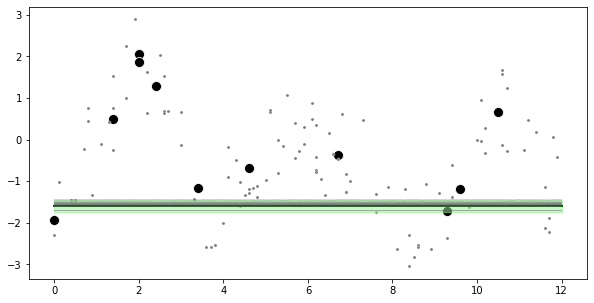

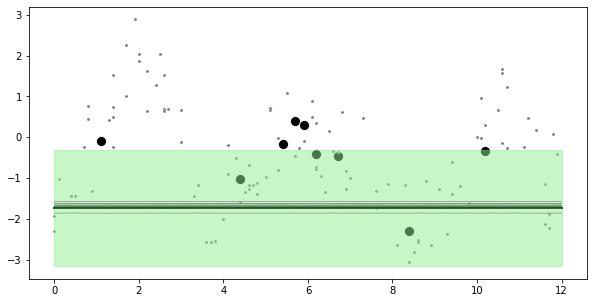

In [64]:
# Plot posterior distribution
p = gp_predict_fun(
    res[best_model[1]][1], 
    X=X, 
    Y=Y[:,0].reshape(-1, 1), 
    x_min=0, 
    x_max=12, 
    x_idx=2, 
    unit_idx=0,
    unit_label=1
)
p = gp_predict_fun(
    res[best_model[1]][1], 
    X=X, 
    Y=Y[:,0].reshape(-1, 1), 
    x_min=0, 
    x_max=12, 
    x_idx=2, 
    unit_idx=0,
    unit_label=2
)

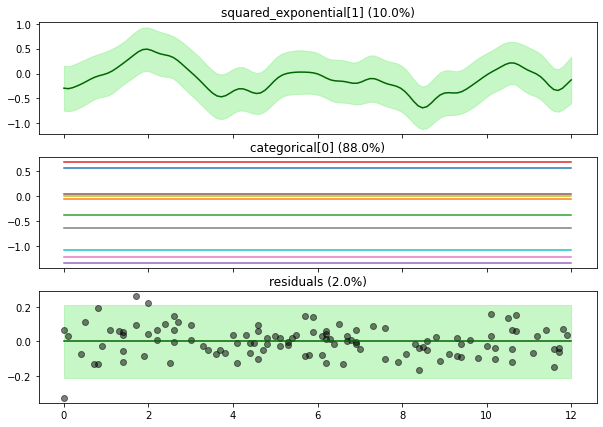

In [66]:
# Print resulting decomposition
pred_kernel_parts(res[best_model[1]][1],
                  best_model[1],
                  x_min=0, x_max=12, x_idx=1,#2, 
                  unit_idx=0, unit_label=5)

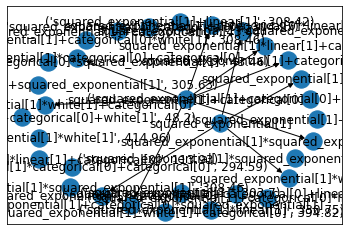

In [67]:
import networkx as nx
graph = nx.DiGraph()
graph.add_edges_from(edges)
graph.add_nodes_from([(k, i[2]) for k, i in res.items()])
nx.draw_networkx(graph)

Kernel 2

In [34]:
res2, edges2 = full_kernel_search(X=X, Y=Y[:,1].reshape(-1, 1), 
                                  kern_list=kernel_list, 
                                  cat_vars=[0, 1], 
                                  max_depth=5,
                                  keep_all=False)
for k,i in sorted(res2.items()):
    print(f'kernel: {k}, depth: {i[3]}, BIC: {i[2]}')
best_model2 = min([(i[2], k) for k, i in res2.items()])
print(best_model2)
res2[best_model2[1]][1]

# Print kernels in order of BIC 
c=0
print('Top five kernels based on BIC:')
for k,v in sorted(res2.items(), key = lambda item: item[1][2]):
    print(f'kernel:{k}, BIC={v[2]}')
    c+=1
    if c==5:
        print('...')
        break

gp_predict_fun(
    res2[best_model2[1]][1], 
    X=X, 
    Y=Y[:,1].reshape(-1, 1), 
    x_min=0, 
    x_max=12, 
    x_idx=2, 
    unit_idx=0,
    unit_label=1
);

Working on depth 1 now
Working on depth 2 now
Found better kernel in next layer, would like to continue search.
Working on depth 3 now


InvalidArgumentError:  Input matrix is not invertible.
	 [[node gradient_tape/triangular_solve/MatrixTriangularSolve (defined at /Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/gpflow/optimizers/scipy.py:173) ]] [Op:__inference__tf_eval_497360]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/triangular_solve/MatrixTriangularSolve:
 Cholesky (defined at /Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/gpflow/models/gpr.py:87)

Function call stack:
_tf_eval


In [ ]:
pred_kernel_parts(res2[best_model2[1]][1], 
                  best_model2[1],
                  x_min=0, x_max=12, x_idx=2, 
                  unit_idx=0, unit_label=0)
# pred_kernel_parts(res2[best_model2[1]][1], 
#                   best_model2[1],
#                   x_min=0, x_max=12, x_idx=2, 
#                   unit_idx=0, unit_label=1)

### Kernel 3

In [ ]:
res3, edges3 = full_kernel_search(X=X, Y=Y[:,2].reshape(-1, 1), 
                                  kern_list=kernel_list, 
                                  cat_vars=[0, 1], 
                                  max_depth=5,
                                  keep_all=False)
for k,i in sorted(res3.items()):
    print(f'kernel: {k}, depth: {i[3]}, BIC: {i[2]}')
best_model3 = min([(i[2], k) for k, i in res3.items()])
# Print kernels in order of BIC 
c=0
print('Top five kernels based on BIC:')
for k,v in sorted(res3.items(), key = lambda item: item[1][2]):
    print(f'kernel:{k}, BIC={v[2]}')
    c+=1
    if c==5:
        print('...')
        break

gp_predict_fun(
    res3[best_model3[1]][1], 
    X=X, 
    Y=Y[:,2].reshape(-1, 1), 
    x_min=0, 
    x_max=12, 
    x_idx=2, 
    unit_idx=0,
    unit_label=1
);

In [ ]:
pred_kernel_parts(res3[best_model3[1]][1], 
                  best_model3[1],
                  x_min=0, x_max=12, x_idx=2, 
                  unit_idx=0, unit_label=5)

### Kernel 4

In [ ]:
res4, edges4 = full_kernel_search(X=X, Y=Y[:,3].reshape(-1, 1), 
                                  kern_list=kernel_list, 
                                  cat_vars=[0, 1], 
                                  max_depth=5,
                                  keep_all=False)

for k,i in sorted(res4.items()):
    print(f'kernel: {k}, depth: {i[3]}, BIC: {i[2]}')
best_model4 = min([(i[2], k) for k, i in res4.items()])
print('')

# Print kernels in order of BIC 
c=0
print('Top five kernels based on BIC:')
for k,v in sorted(res4.items(), key = lambda item: item[1][2]):
    print(f'kernel:{k}, BIC={v[2]}')
    c+=1
    if c==5:
        print('...')
        break

gp_predict_fun(
    res4[best_model4[1]][1], 
    X=X, 
    Y=Y[:,3].reshape(-1, 1), 
    x_min=0, 
    x_max=12, 
    x_idx=2, 
    unit_idx=0,
    unit_label=0
);

pred_kernel_parts(res4[best_model4[1]][1], 
                  best_model4[1],
                  x_min=0, x_max=12, x_idx=2, 
                  unit_idx=0, unit_label=0)

## Kernel search operator

In [ ]:
%%time
model_out, search_edges = run_search_operator(X=X,
                                Y=Y[:,0].reshape(-1, 1),
                                kern_list=[gpflow.kernels.Linear(),
                                           gpflow.kernels.SquaredExponential(),
                                           gpflow.kernels.Matern32(),
                                           #gpflow.kernels.Periodic(
                                           #    gpflow.kernels.SquaredExponential()
                                           #)
                                          ],
                                cat_vars=[0, 1],
                                max_depth=10,
                                keep_all=False)
gp_predict_fun(model_out,
               X=X,
               Y=Y[:,0],
               x_min=-1,
               x_max=13,
               x_idx=2,
               unit_idx=0,
               unit_label=1)

In [ ]:
import networkx as nx
graph = nx.DiGraph()
graph.add_edges_from(edges)
# graph.add_nodes_from([(k, i[2]) for k, i in res.items()])
nx.draw_networkx(graph)

In [ ]:
%%time
model_out2 = run_search_operator(X=X,
                                 Y=Y[:,1].reshape(-1, 1),
                                 kern_list=[gpflow.kernels.Linear(),
                                            gpflow.kernels.SquaredExponential(),
                                            gpflow.kernels.Matern32(),
                                            #gpflow.kernels.Periodic(
                                            #    gpflow.kernels.SquaredExponential()
                                            #)
                                           ],
                                 cat_vars=[0, 1],
                                 max_depth=10,
                                 keep_all=False)
gp_predict_fun(model_out2,
               X=X,
               Y=Y[:,1],
               x_min=-1,
               x_max=13,
               x_idx=2,
               unit_idx=0,
               unit_label=1)

In [ ]:
%%time
model_out3 = run_search_operator(X=X,
                                 Y=Y[:,2].reshape(-1, 1),
                                 kern_list=[gpflow.kernels.Linear(),
                                            gpflow.kernels.SquaredExponential(),
                                            gpflow.kernels.Matern32(),
                                            #gpflow.kernels.Periodic(
                                            #    gpflow.kernels.SquaredExponential()
                                            #)
                                           ],
                                 cat_vars=[0, 1],
                                 max_depth=10,
                                 keep_all=False)
gp_predict_fun(model_out3,
               X=X,
               Y=Y[:,2],
               x_min=-1,
               x_max=13,
               x_idx=2,
               unit_idx=0,
               unit_label=1)

In [ ]:
%%time
model_out4 = run_search_operator(X=X,
                                 Y=Y[:,3].reshape(-1, 1),
                                 kern_list=[gpflow.kernels.Linear(),
                                            gpflow.kernels.SquaredExponential(),
                                            gpflow.kernels.Matern32(),
                                            #gpflow.kernels.Periodic(
                                            #    gpflow.kernels.SquaredExponential()
                                            #)
                                           ],
                                 cat_vars=[0, 1],
                                 max_depth=10,
                                 keep_all=False)
gp_predict_fun(model_out4,
               X=X,
               Y=Y[:,3],
               x_min=-1,
               x_max=13,
               x_idx=2,
               unit_idx=0,
               unit_label=1)

In [ ]:
model_out4